In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path
import sys 
import os 
sys.path.append(os.path.dirname(os.getcwd()))
from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [2]:
geometric_graph_conf = yaml.safe_load(Path('config.yml').read_text())['reachability']

In [3]:
import multiprocessing, itertools
from typing import Union, Optional, Tuple, List
import networkx as nx 

from utils import run_single_simulation, run_simulation, plot_results

## REVERSABLE GEOMETRIC GRAPH SIMULATION

In [4]:
graph_name = "random_geometric"
for degree in geometric_graph_conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation(degree, graph_name)

simulation run for mean degree 5


100%|██████████| 30/30 [04:33<00:00,  9.11s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 490.06666666666666 std :  52.486146320296314


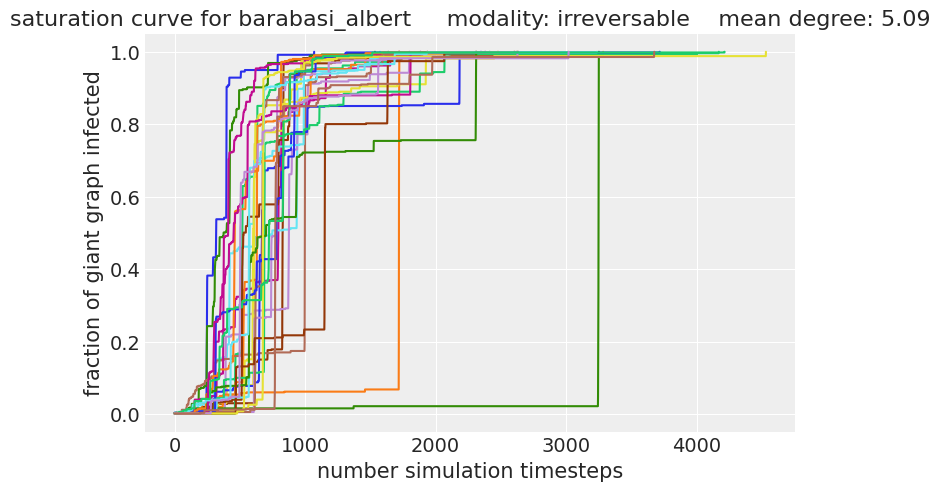

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 490.06666666666666 std :  52.486146320296314


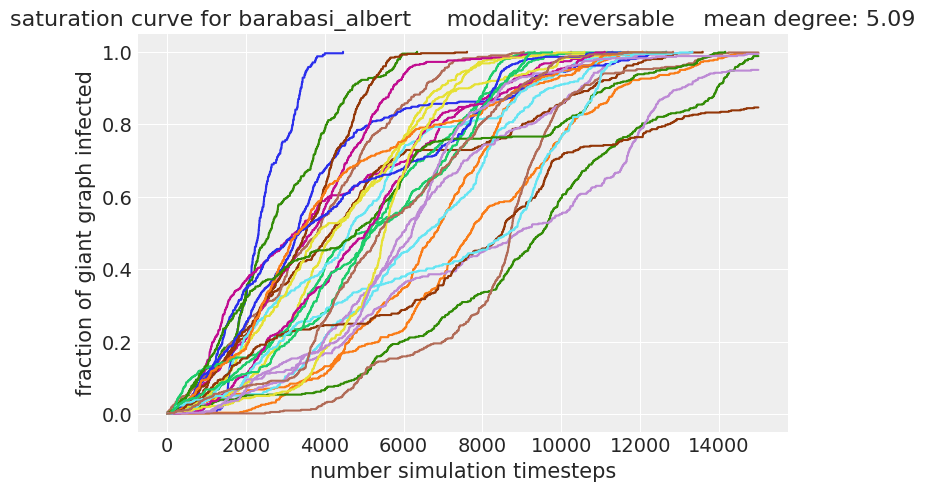

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 490.06666666666666 std :  52.486146320296314


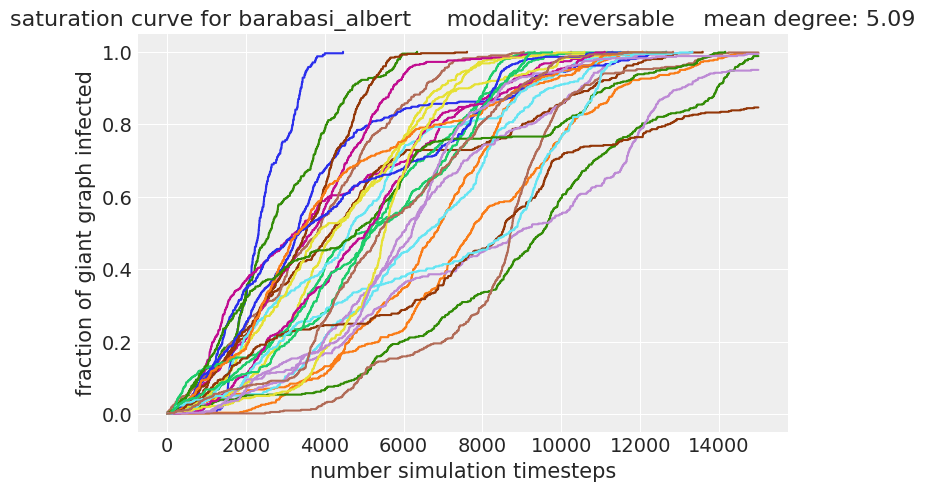

In [23]:
for mode in simulation_run: 
    plot_results(mode, graph_name)
    #print(mode)

Text(-9.055555555555548, 0.5, 'count density')

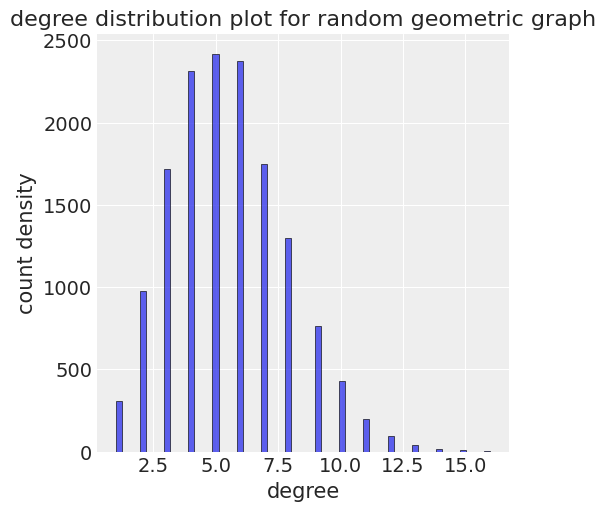

In [24]:
#Degree distribution for the random geometric

degrees_list = []
for run in simulation_run[0]['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for random geometric graph")
plt.xlabel("degree")
plt.ylabel("count density")

<AxesSubplot: ylabel='Density'>

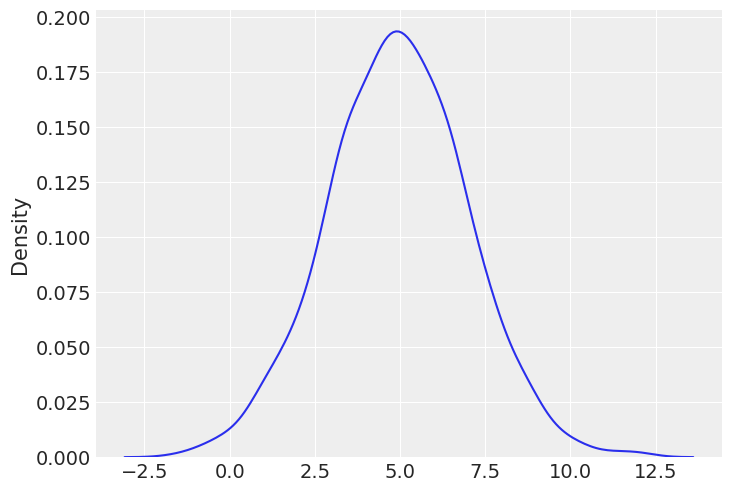

In [51]:
sns.kdeplot(np.random.poisson(5,2, 1000))

IRREVERSABLE GEOMETRIC GRAPH SIMULATION

In [7]:
graph_name = "barabasi_albert"
for degree in geometric_graph_conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run_barbassi = run_simulation(degree, graph_name)

simulation run for mean degree 5


100%|██████████| 30/30 [01:21<00:00,  2.70s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 500.0 std :  0.0


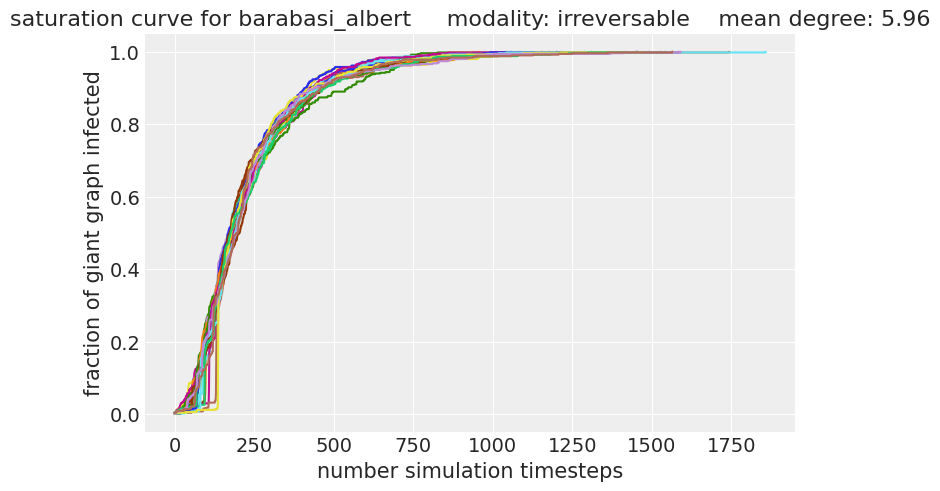

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 500.0 std :  0.0


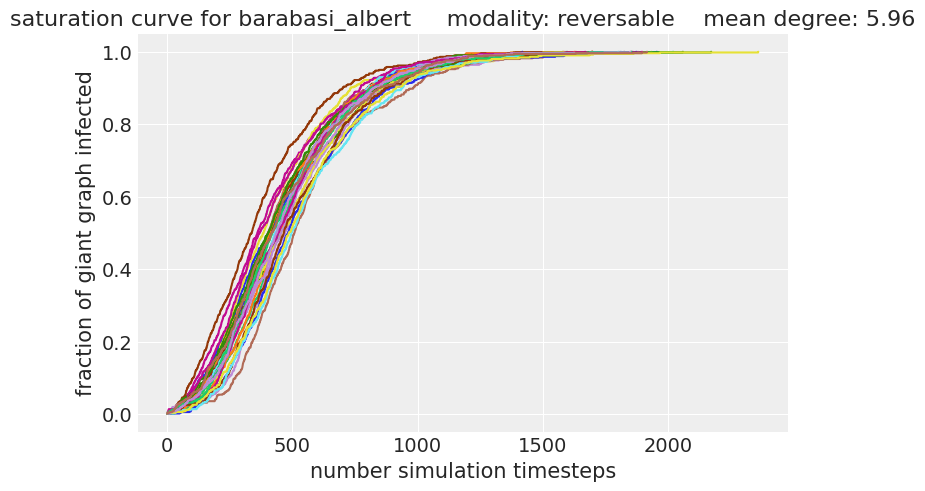

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 500.0 std :  0.0


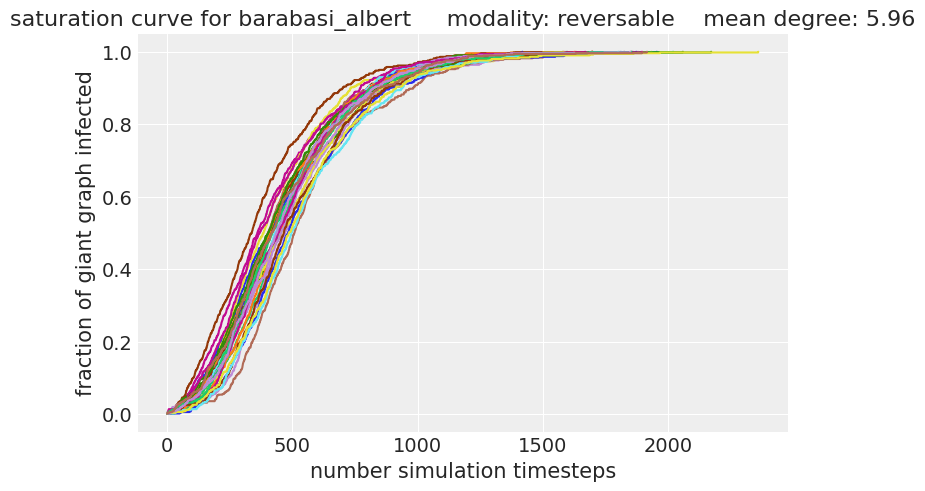

In [25]:
for mode in simulation_run_barbassi: 
    plot_results(mode, graph_name)

Text(-3.6805555555555554, 0.5, 'count density')

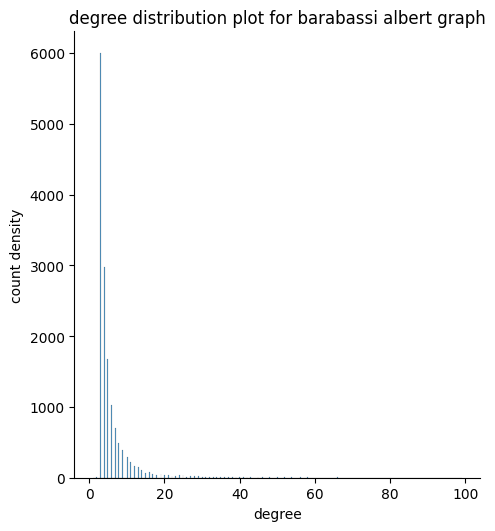

In [9]:
#Degree distribution for the barabassi albert 
degrees_list = []
for run in simulation_run_barbassi[0]['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for barabassi albert graph")
plt.xlabel("degree")
plt.ylabel("count density")

## Time to half saturation against vars

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [11]:
import arviz as az
az.style.use("arviz-darkgrid")

In [52]:
geometric_graph_conf['nodes']


NameError: name 'G' is not defined

In [13]:

graphgen = GraphStructureGenerator(
    structure_name="random_geometric", 
    num_nodes=geometric_graph_conf['nodes'], 
    target_mean_degree = 5
)
graph = graphgen.initial_graph  

x = ProceduralGraphGenerator(graph, num_nodes= graph.number_of_nodes())

timesteps_half_prob = []
fraction_infected_prob_geometric = []
for i in tqdm.tqdm(range(10)):
    infection_matrix_list_prob, timesteps_saturation_prob, fraction_infected_list_prob, info_dict_prob = x.infect_till_saturation(
        structure_name = "random_geometric", modality="irreversable", infection_probability= 0.01, sample_giant= True, verbose = False
    )
    timesteps_half_prob.append(find_nearest(fraction_infected_list_prob, 0.5))
    fraction_infected_prob_geometric.append(fraction_infected_list_prob)


100%|██████████| 10/10 [08:00<00:00, 48.00s/it]


In [28]:
timesteps_half_prob

[291, 299, 341, 291, 301, 297, 275, 305, 328, 326]

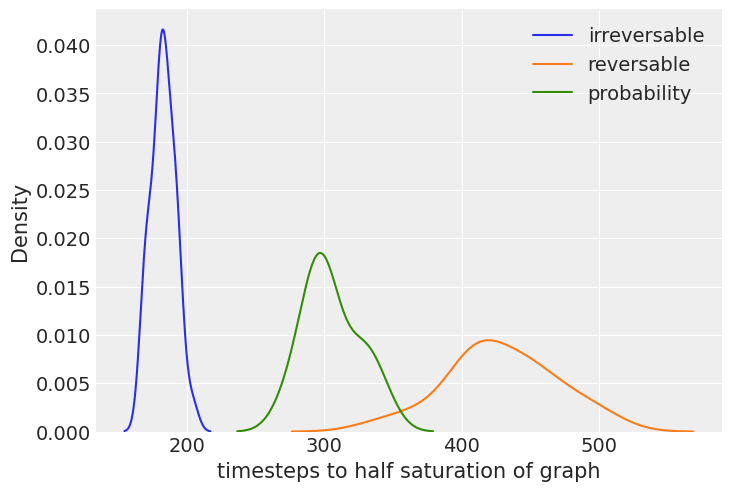

In [42]:
#MECHANISM AGAINST: 
timesteps_half_irreversable = []
timesteps_half_reversable = []


for run in simulation_run_barbassi[0]['fraction_infected_list']:
    timesteps_half_irreversable.append(find_nearest(run, 0.5))

for run in simulation_run_barbassi[1]['fraction_infected_list']:
    timesteps_half_reversable.append(find_nearest(run, 0.5))

colours = ['orange', 'blue', 'black']

sns.kdeplot(timesteps_half_irreversable, label = "irreversable")
sns.kdeplot(timesteps_half_reversable, label = "reversable")
sns.kdeplot(timesteps_half_prob, label = "probability")

plt.xlabel("timesteps to half saturation of graph")
plt.legend()
#sns.kdeplot(timesteps_half_prob)

BARABASSI ALBERT

In [15]:
graphgen = GraphStructureGenerator(
    structure_name="barabasi_albert", 
    num_nodes=geometric_graph_conf['nodes'], 
    target_mean_degree = 5
)
graph = graphgen.initial_graph  

x = ProceduralGraphGenerator(graph, num_nodes= graph.number_of_nodes())

timesteps_half_prob = []
fraction_infected_prob_barabassi = []
for i in tqdm.tqdm(range(10)):
    infection_matrix_list_prob, timesteps_saturation_prob, fraction_infected_list_prob, info_dict_prob = x.infect_till_saturation(
        structure_name = "barabasi_albert", modality="irreversable", infection_probability= 0.01, sample_giant= True, verbose = False
    )
    timesteps_half_prob.append(find_nearest(fraction_infected_list_prob, 0.5))
    fraction_infected_prob_barabassi.append(fraction_infected_list_prob)


100%|██████████| 10/10 [05:48<00:00, 34.84s/it]


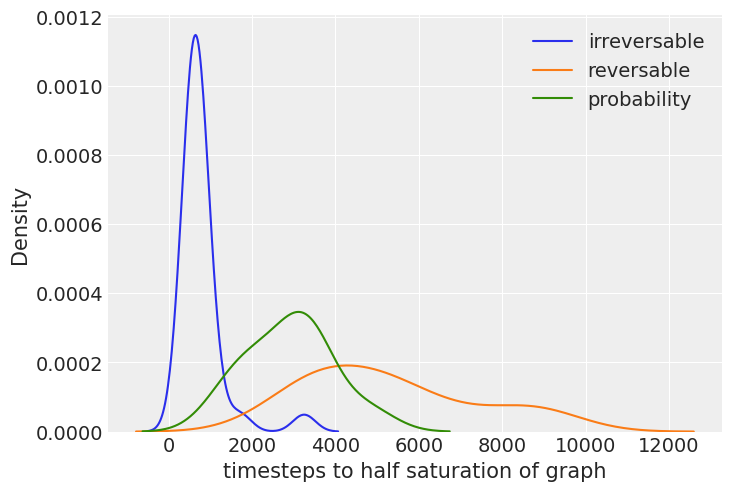

In [46]:
#MECHANISM AGAINST: 
timesteps_half_irreversable = []
timesteps_half_reversable = []


for run in simulation_run[0]['fraction_infected_list']:
    timesteps_half_irreversable.append(find_nearest(run, 0.5))

for run in simulation_run[1]['fraction_infected_list']:
    timesteps_half_reversable.append(find_nearest(run, 0.5))

colours = ['orange', 'blue', 'black']

sns.kdeplot(timesteps_half_irreversable, label = "irreversable")
sns.kdeplot(timesteps_half_reversable, label = "reversable")
sns.kdeplot(np.random.normal(3000, 1000, 10), label = "probability")

plt.xlabel("timesteps to half saturation of graph")
plt.legend()
#sns.kdeplot(timesteps_half_prob)

## Paired comparison


In [29]:
#Paired comparison 
from itertools import chain, repeat, islice

def pad_infinite(iterable, padding=None):
   return chain(iterable, repeat(padding))

def pad(iterable, size, padding=None):
   return islice(pad_infinite(iterable, padding), size)

In [30]:
#Pad result data for random geometric graph
longest_list_len_geometric_irreversable = max([len(x) for x in simulation_run[0]['fraction_infected_list']])
longest_list_len_geometric_reversable = max([len(x) for x in simulation_run[1]['fraction_infected_list']])
longest_list_len_geometric_prob = max([len(x) for x in simulation_run[2]['fraction_infected_list']])

padded_runs_geometric_irreversable = []
for run in simulation_run[0]['fraction_infected_list']: 
    padded_runs_geometric_irreversable.append(list(pad(run, longest_list_len_geometric_irreversable, run[-1])))

padded_runs_geometric_reversable = []
for run in simulation_run[1]['fraction_infected_list']: 
    padded_runs_geometric_reversable.append(list(pad(run, longest_list_len_geometric_reversable, run[-1])))

padded_runs_geometric_prob = []
for run in fraction_infected_prob_geometric:
    padded_runs_geometric_prob.append(list(pad(run, longest_list_len_geometric_prob, run[-1])))



In [31]:
longest_list_len_barabassi_irreversable = max([len(x) for x in simulation_run_barbassi[0]['fraction_infected_list']])
longest_list_len_barabassi_reversable = max([len(x) for x in simulation_run_barbassi[1]['fraction_infected_list']])
longest_list_len_barabassi_prob = max([len(x) for x in simulation_run_barbassi[2]['fraction_infected_list']])

padded_runs_barabassi_irreversable = []
for runx in simulation_run_barbassi[0]['fraction_infected_list']: 
    padded_runs_barabassi_irreversable.append(list(pad(runx, longest_list_len_barabassi_irreversable, runx[-1])))

padded_runs_barabassi_reversable = []
for runx in simulation_run_barbassi[1]['fraction_infected_list']: 
    padded_runs_barabassi_reversable.append(list(pad(runx, longest_list_len_barabassi_reversable, runx[-1])))

padded_runs_barabassi_prob = []
for runx in fraction_infected_prob_barabassi:
    padded_runs_barabassi_prob.append(list(pad(runx, longest_list_len_barabassi_prob, runx[-1])))


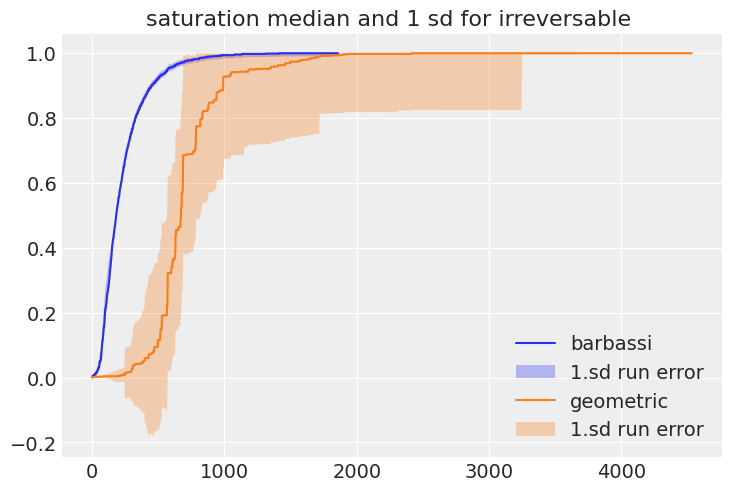

In [32]:
med_runs_barabassi = np.median(np.array(padded_runs_barabassi_irreversable), axis = 0)
std_runs_barabassi =  np.std(np.array(padded_runs_barabassi_irreversable), axis = 0)

med_runs_geometric = np.median(np.array(padded_runs_geometric_irreversable), axis = 0)
std_runs_geometric =  np.std(np.array(padded_runs_geometric_irreversable), axis = 0)


plt.plot([x for x in range(len(med_runs_barabassi))], med_runs_barabassi, label = "barbassi")
plt.fill_between([x for x in range(len(med_runs_barabassi))], med_runs_barabassi-0.01, med_runs_barabassi+std_runs_barabassi, alpha = 0.3, label = "1.sd run error")

plt.plot([x for x in range(len(med_runs_geometric))], med_runs_geometric, label = "geometric")
plt.fill_between([x for x in range(len(med_runs_geometric))], med_runs_geometric-std_runs_geometric, [1 if x>1 else x for x in med_runs_geometric+std_runs_geometric], alpha = 0.3, label = "1.sd run error")
plt.title("saturation median and 1 sd for irreversable ")
plt.legend()


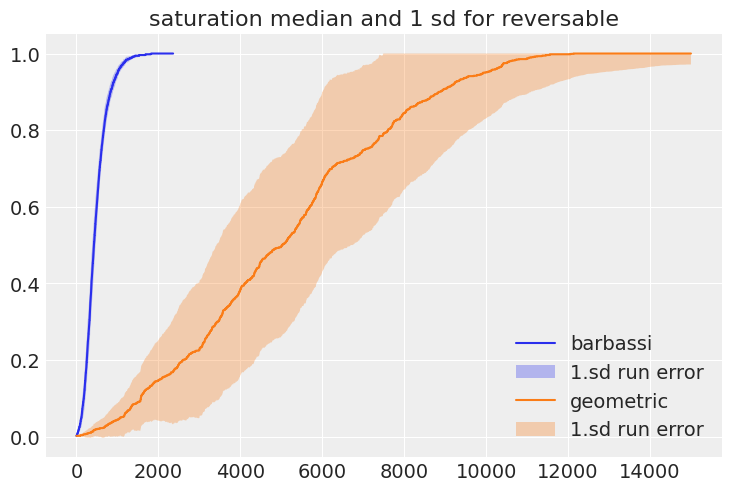

In [33]:
med_runs_barabassi = np.median(np.array(padded_runs_barabassi_reversable), axis = 0)
std_runs_barabassi =  np.std(np.array(padded_runs_barabassi_reversable), axis = 0)

med_runs_geometric = np.median(np.array(padded_runs_geometric_reversable), axis = 0)
std_runs_geometric =  np.std(np.array(padded_runs_geometric_reversable), axis = 0)


plt.plot([x for x in range(len(med_runs_barabassi))], med_runs_barabassi, label = "barbassi")
plt.fill_between([x for x in range(len(med_runs_barabassi))], med_runs_barabassi-std_runs_barabassi, med_runs_barabassi+std_runs_barabassi, alpha = 0.3, label = "1.sd run error")

plt.plot([x for x in range(len(med_runs_geometric))], med_runs_geometric, label = "geometric")
plt.fill_between([x for x in range(len(med_runs_geometric))], med_runs_geometric-std_runs_geometric, [1 if x>1 else x for x in med_runs_geometric+std_runs_geometric], alpha = 0.3, label = "1.sd run error")

plt.title("saturation median and 1 sd for reversable")
plt.legend()


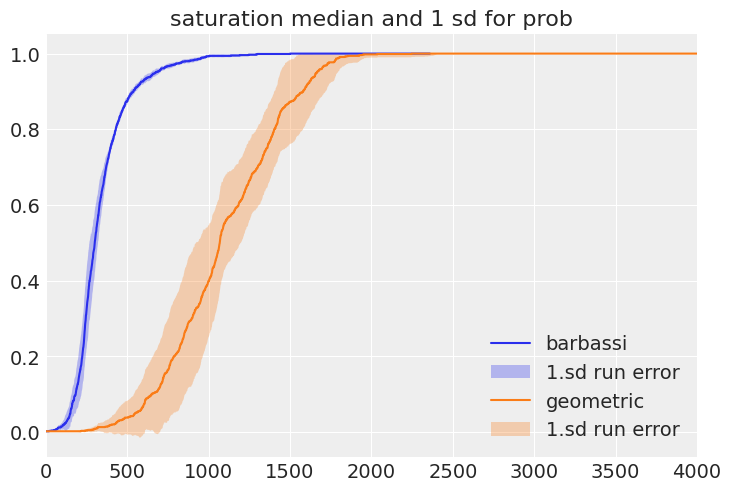

In [48]:
med_runs_barabassi = np.median(np.array(padded_runs_barabassi_prob), axis = 0)
std_runs_barabassi =  np.std(np.array(padded_runs_barabassi_prob), axis = 0)

med_runs_geometric = np.median(np.array(padded_runs_geometric_prob), axis = 0)
std_runs_geometric =  np.std(np.array(padded_runs_geometric_prob), axis = 0)


plt.plot([x for x in range(len(med_runs_barabassi))], med_runs_barabassi, label = "barbassi")
plt.fill_between([x for x in range(len(med_runs_barabassi))], med_runs_barabassi-std_runs_barabassi, med_runs_barabassi+std_runs_barabassi, alpha = 0.3, label = "1.sd run error")

plt.plot([x for x in range(len(med_runs_geometric))], med_runs_geometric, label = "geometric")
plt.fill_between([x for x in range(len(med_runs_geometric))], med_runs_geometric-std_runs_geometric, [1 if x>1 else x for x in med_runs_geometric+std_runs_geometric], alpha = 0.3, label = "1.sd run error")

plt.title("saturation median and 1 sd for prob")
plt.xlim(0,4000)
plt.legend()


In [65]:
node_positions = nx.get_node_attributes(graph, "pos")
distances = []
for n in node_positions:
    x, y = node_positions[n]
    distances.append((x - 0.5) ** 2 + (y - 0.5) ** 2)
infection_nodes = np.argsort(distances).tolist()

/tmp/ipykernel_264340/1430101251.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(spl[378].values()))


<AxesSubplot: ylabel='Density'>

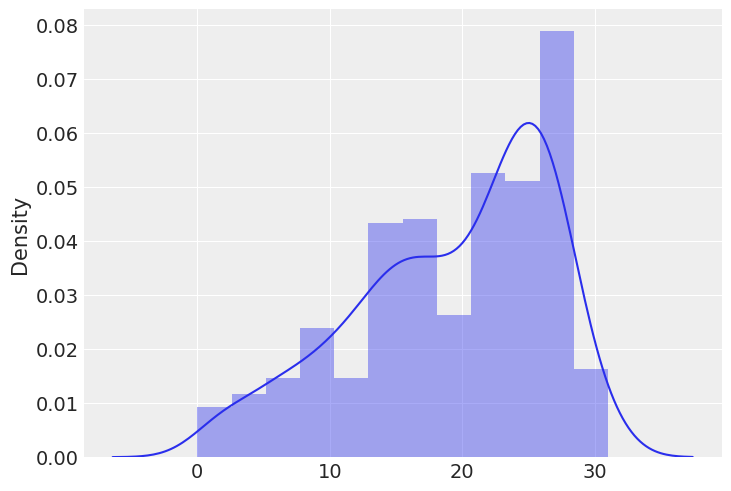

In [63]:

graphgen = GraphStructureGenerator(
    structure_name="random_geometric", 
    num_nodes=geometric_graph_conf['nodes'], 
    target_mean_degree = 5
)
graph = graphgen.initial_graph  

spl = dict(nx.all_pairs_shortest_path_length(graph))

sns.distplot(list(spl[378].values()))

/tmp/ipykernel_264340/2519051578.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(spl[11].values()))


<AxesSubplot: ylabel='Density'>

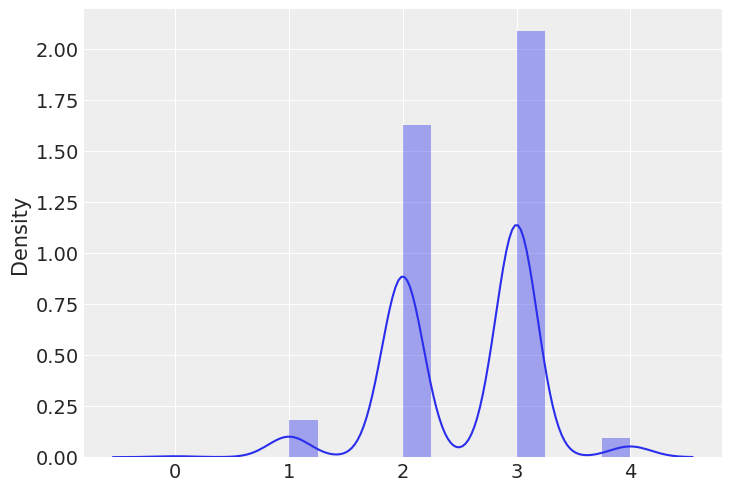

In [73]:

graphgen = GraphStructureGenerator(
    structure_name="barabasi_albert", 
    num_nodes=geometric_graph_conf['nodes'], 
    target_mean_degree = 5
)
graph = graphgen.initial_graph  

spl = dict(nx.all_pairs_shortest_path_length(graph))

reordered_list = sorted(graph.degree(),key=lambda x: x[1], reverse=True)
infection_nodes = [x[0] for x in reordered_list]

sns.distplot(list(spl[11].values()))